# Practical 2

**Group composition**: 
- Lucie-Marie BOSCHIAN CAMPANER &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 12

**Author**: *Lucas RODRIGUEZ*

## First steps

In [12]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Air Quality**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Air+Quality
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [13]:
# Importing the given dataset
file_name = "data/AirQualityUCI.csv"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                #index_col="Date",
                na_values=np.nan,
                decimal=",") # Floating point separator for implicit casting

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [14]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


(9471, 17)

In [15]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.0,-34.208,77.657,-200.0,0.600,1.500,2.600,11.900
PT08.S1(CO),9357.0,1048.990,329.833,-200.0,921.000,1053.000,1221.000,2040.000
NMHC(GT),9357.0,-159.090,139.789,-200.0,-200.000,-200.000,-200.000,1189.000
C6H6(GT),9357.0,1.866,41.380,-200.0,4.000,7.900,13.600,63.700
PT08.S2(NMHC),9357.0,894.595,342.333,-200.0,711.000,895.000,1105.000,2214.000
NOx(GT),9357.0,168.617,257.434,-200.0,50.000,141.000,284.000,1479.000
PT08.S3(NOx),9357.0,794.990,321.994,-200.0,637.000,794.000,960.000,2683.000
NO2(GT),9357.0,58.149,126.940,-200.0,53.000,96.000,133.000,340.000
PT08.S4(NO2),9357.0,1391.480,467.210,-200.0,1185.000,1446.000,1662.000,2775.000
PT08.S5(O3),9357.0,975.072,456.938,-200.0,700.000,942.000,1255.000,2523.000


The dataset initially contains 9471 rows and 16 columns.

### Dataset description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 


---

0. Date (format: DD/MM/YYYY)
1. Time (format: HH.MM.SS)
2. True hourly averaged concentration CO in $\text{mg}/\text{m}^3$ (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) 
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) 
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) 
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) 
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature (in °C)
13. Relative Humidity (%) 
14. AH: Absolute Humidity


---

Add the choice of target/features


### Dataset references & License



Saverio De Vito (saverio.devito@enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

In [16]:
# A quick overview of the dataset structure
df.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,NaN,NaN
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,NaN,NaN
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,NaN,NaN


## Data pre-processing & Data-cleaning

### Drop duplicates

We can handle duplicate rows by using the following instruction


In [17]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(9358, 17)

We have successfully eliminated $9471 - 9347 = \fbox{124}$ rows (especially, most of them were rows filled of NaN values (see next section). 

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

In [18]:
df.dropna(how="all", inplace=True)
df.shape

(9357, 17)

In [19]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
Unnamed: 15         0
Unnamed: 16         0
dtype: int64

### Drop useless columns

We can easily see, thanks to the previous cell, that the last two columns are completely empty

$\Longrightarrow$ We immediately remove them.

In [20]:
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


### Customizing the inner structure of the dataset

We observe that `Date` and `Time` are `object`-typed. Since we want to perform a regression model on our data, we want to explain the target variable with the widest subset of possible features.



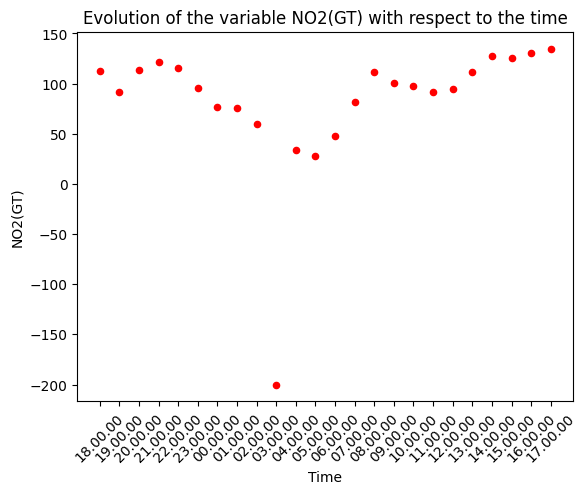

In [21]:
_ = df[0:24].plot.scatter("Time", "NO2(GT)", 
                      rot=45, 
                      color="red"
                     )
_ = plt.title("Evolution of the variable NO2(GT) with respect to the time")

We can see that, on the scale of only one day, the evolution of concentration of some substances is clearly highlighted here.

We have:
- `Date`: DD/MM/YYYY
- `Time`: HH.MM.SS (but the frequency of observation is an hourly-basis.



We also observe that the date range goes from 10/03/2004 to 03/04/2005; we can remove the year detail and only encode the month as follows:
- March 2004 $\longrightarrow 0$
- April 2004 $\longrightarrow 1$ 
- ...

As shown in the below figures, we see that there is no clear reason in keeping the days into the dataset; we remove them.

<img src="img/cal1.png" width=600>

<img src="img/cal2.png" width=600>


In fact, there is no need to keep the days because of the combination of the record id (represented by the index of the row) and the hours.


To conclude, we have decided to keep the months (as an encoded field) and the hours (the minutes and seconds dedicated fields are empty because of the hourly refresh time frequency.

In [22]:
# Creating the month column
get_month = lambda x:x.split("/")[1][1] if x.split("/")[1][0] == '0' else x.split("/")[1]
df["Month"] = df["Date"].apply(get_month)
df["Month"] = pd.to_numeric(df["Month"])

In [23]:
# Creating the hour column
get_hour = lambda x:x.split(".")[0][0] if x.split(".")[0][1] == '0' else x.split(".")[0]
df["Hour"] = df["Time"].apply(get_hour)
df["Hour"] = pd.to_numeric(df["Hour"])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Month          9357 non-null   int64  
 16  Hour           9357 non-null   int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 1.

In [25]:
# Dropping the column Date and Time
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


### Thresholding the values ($-200 = \text{NaN}$)

We have remarked the following highlight from the dataset webpage:
> Missing values are tagged with -200 value. 

We have to replace all values under $-200$ by a NaN item; we will then deal with them in the next section:

In [26]:
columns_float = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH']
df[df[columns_float] <= -200] = np.nan

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset; we have to remove all of them.

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset.

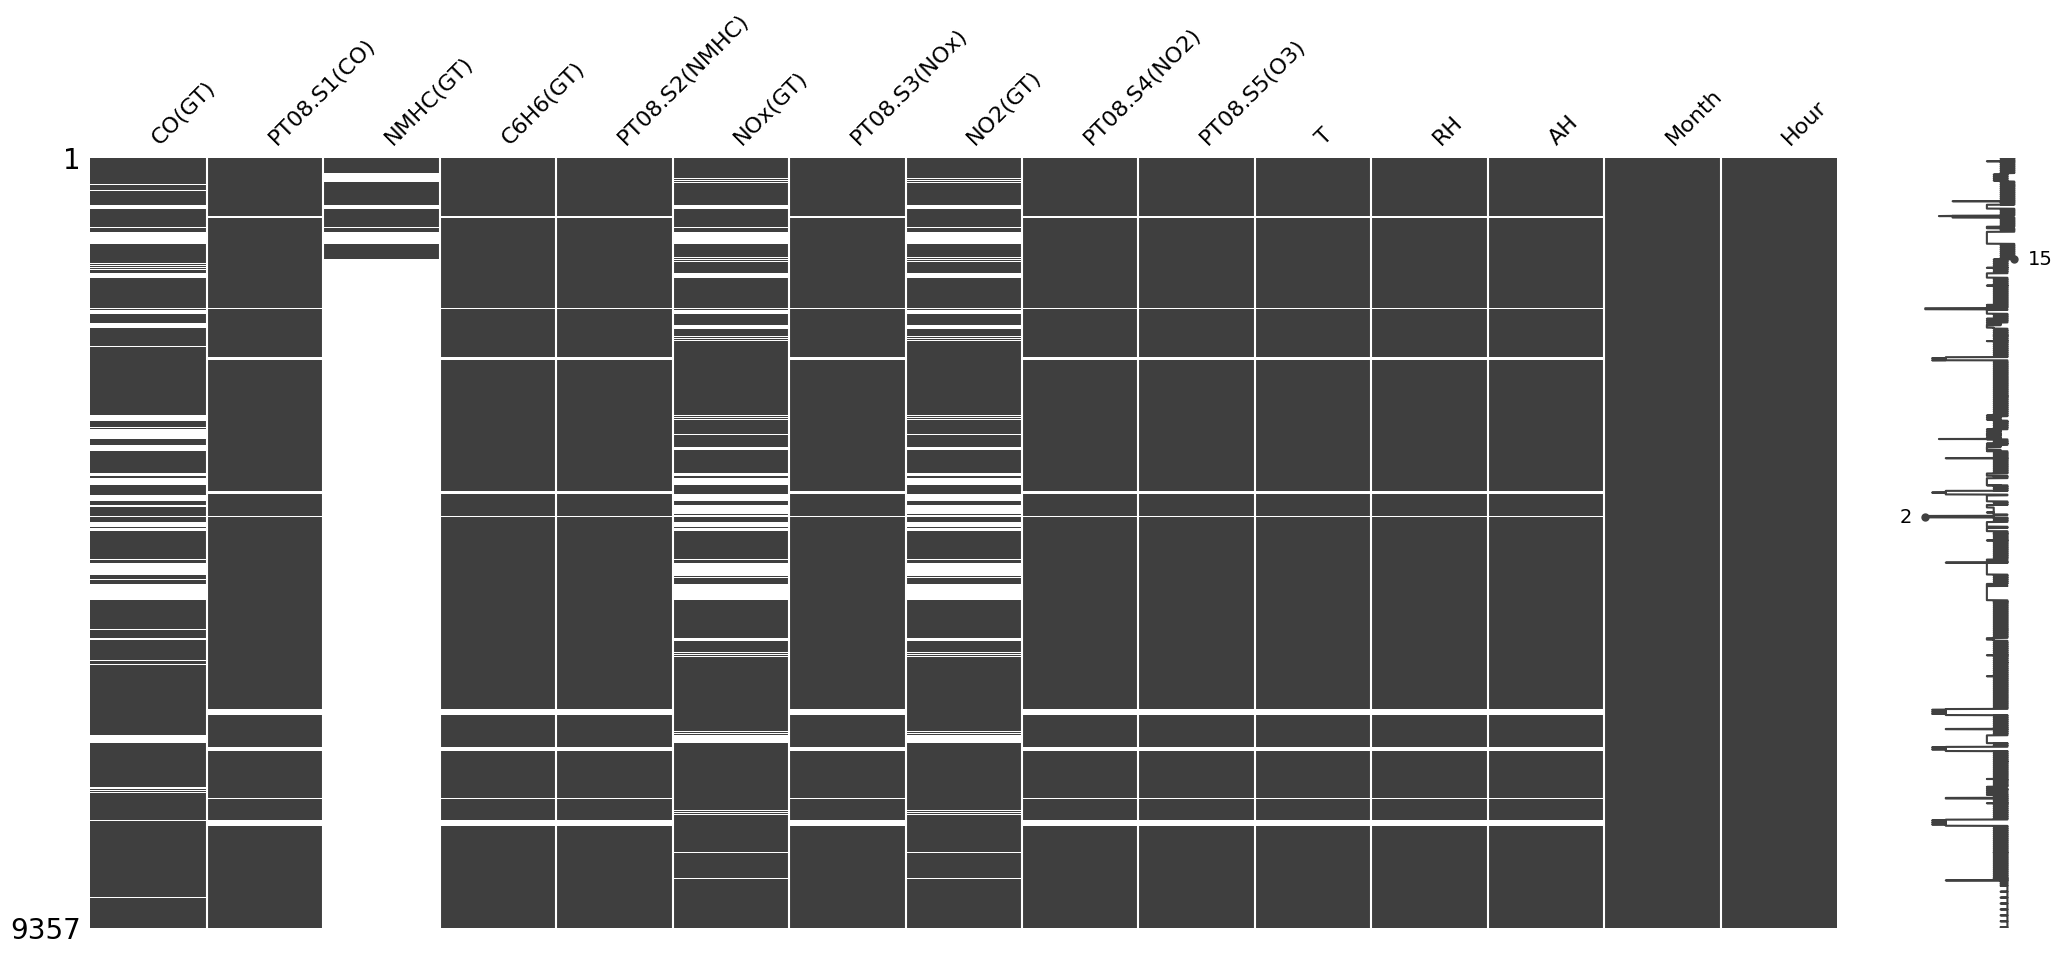

In [27]:
_ = msno.matrix(df)

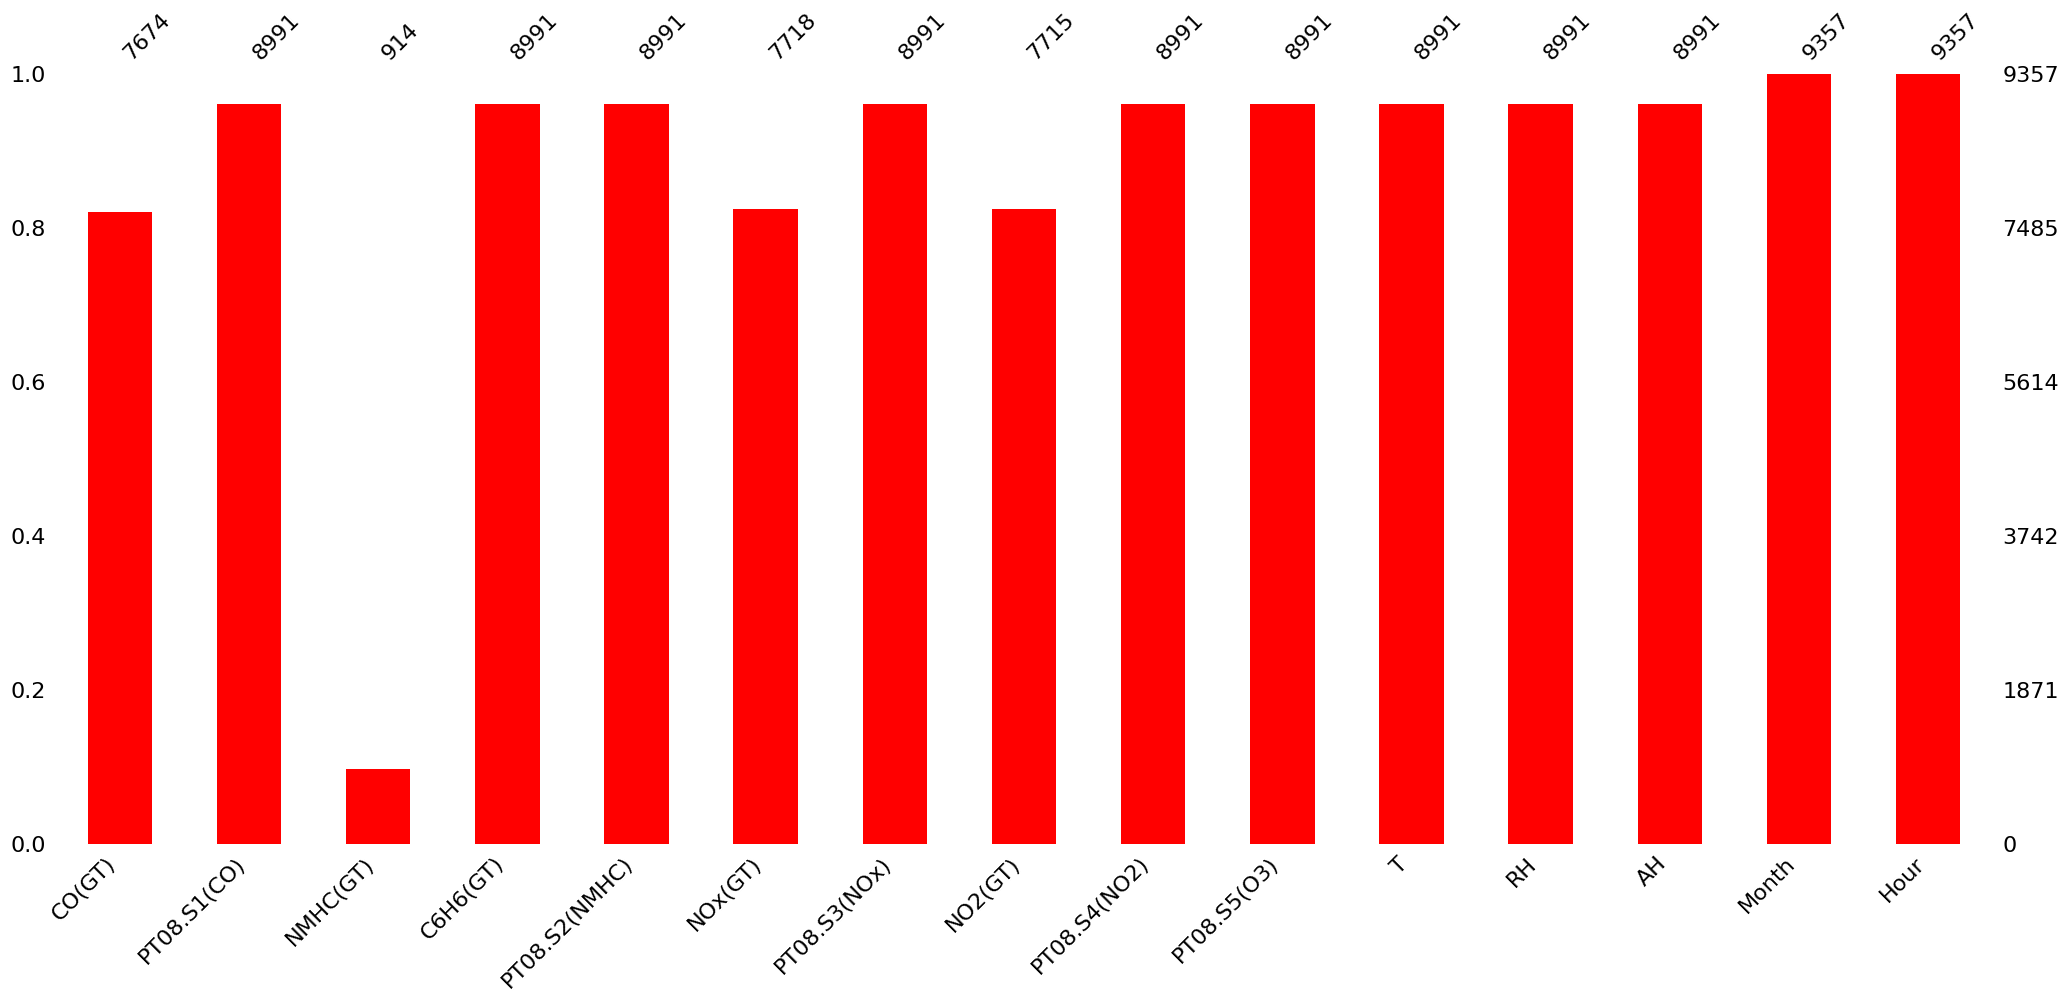

In [28]:
_ = msno.bar(df, color="red")

The feature : **`NMHC(GT)`** has a high proportion of NaN elements 

$\Longrightarrow$ This column cannot provide meaningful conclusion on the selected target.

$\Longrightarrow$ We decide to remove the column **`NMHC(GT)`**.

In [29]:
# Dropping the column NMHC(GT)
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['NMHC(GT)'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Column already removed.")
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


The other columns have a proportion of non-NaN greater than $80 \ \%$, which contains most of the information of the corresponding feature; we can replace these NaN values by a significant statistical indicator such as : median or mean value.

$\Longrightarrow$ We choose the **average** value here.

In [30]:
# Removing the NMHC(GT) column
try:
    columns_float.remove('NMHC(GT)')
except ValueError:
    pass
columns_float
for c in columns_float:
    df[c].fillna(df[c].mean(), inplace=True) # or .median()

In [31]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Month            0.0
Hour             0.0
dtype: float64

We're good to go !

In [32]:
df.head(10)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.000000,1056.0,113.000000,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.000000,1174.0,92.000000,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.000000,1140.0,114.000000,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.000000,1092.0,122.000000,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.000000,1205.0,116.000000,1490.0,1110.0,11.2,59.6,0.7888,3,22
5,1.2,1197.0,4.7,750.0,89.000000,1337.0,96.000000,1393.0,949.0,11.2,59.2,0.7848,3,23
6,1.2,1185.0,3.6,690.0,62.000000,1462.0,77.000000,1333.0,733.0,11.3,56.8,0.7603,3,0
7,1.0,1136.0,3.3,672.0,62.000000,1453.0,76.000000,1333.0,730.0,10.7,60.0,0.7702,3,1
8,0.9,1094.0,2.3,609.0,45.000000,1579.0,60.000000,1276.0,620.0,10.7,59.7,0.7648,3,2
9,0.6,1010.0,1.7,561.0,246.896735,1705.0,113.091251,1235.0,501.0,10.3,60.2,0.7517,3,3


In [33]:
# Saving the pre-processed dataset on disk
df.to_csv(path_or_buf="data/processed_dataset.csv",
         sep=";",
         header=True)

### Features normalization

We can use the `MinMaxScaler` or the `StandardScaler` from *scikit-learn*.

In [34]:
# Normalization process using the MinMaxScaler processor
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

In [35]:
# New results scaled and centered
df.head(10)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.181818,0.782609
1,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.181818,0.826087
2,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.181818,0.086957
3,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.181818,0.913043
4,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.181818,0.956522
5,0.093220,0.394831,0.072327,0.200437,0.058903,0.429903,0.278107,0.378597,0.316247,0.281720,0.628931,0.293261,0.181818,1.000000
6,0.093220,0.386217,0.055031,0.167668,0.040623,0.482846,0.221893,0.351619,0.222415,0.283871,0.598742,0.281288,0.181818,0.000000
7,0.076271,0.351041,0.050314,0.157837,0.040623,0.479034,0.218935,0.351619,0.221112,0.270968,0.638994,0.286126,0.181818,0.043478
8,0.067797,0.320890,0.034591,0.123430,0.029113,0.532402,0.171598,0.325989,0.173328,0.270968,0.635220,0.283487,0.181818,0.086957
9,0.042373,0.260589,0.025157,0.097215,0.165807,0.585769,0.328672,0.307554,0.121633,0.262366,0.641509,0.277085,0.181818,0.130435


In [36]:
# Saving the pre-processed dataset AFTER normalization on disk
df.to_csv(path_or_buf="data/processed_dataset_norm.csv",
         sep=";",
         header=True)

### $X$/$Y$ dataset split

We now have to split the main dataset into $X$ and $Y$ dataframes.

As a reminder:
- $X$ represents the features matrix
- $Y$ represents the target variable (as a vector or Pandas Series to be more precise)

In [37]:
# Splitting the dataset
X = df.copy() # X as a deep copy for security reason
Y = X.pop("T")

In [38]:
# Features
X.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,Month,Hour
0,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.499371,0.280066,0.181818,0.782609
1,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.484277,0.264282,0.181818,0.826087
2,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.563522,0.276352,0.181818,0.086957
3,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.638994,0.294190,0.181818,0.913043
4,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.633962,0.295216,0.181818,0.956522


In [39]:
# Target
Y.head()

0    0.333333
1    0.326882
2    0.296774
3    0.277419
4    0.281720
Name: T, dtype: float64

### Handling outliers

<p style="color:red"> 
    <b>WARNING</b>: This step has to be performed <b>RIGHT AFTER</b> the train/test/validation split <b>AND ONLY</b> on the train set.
</p>

In order to check the presence of outliers within our dataset, we analyze the box-plot of each column.

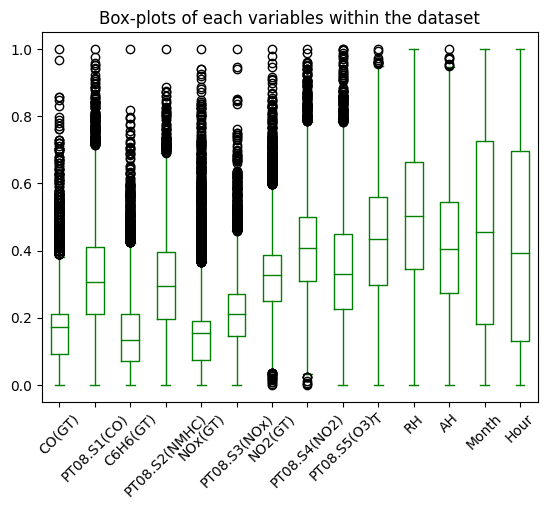

In [40]:
df.plot(kind="box",
       title="Box-plots of each variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)

We can observe a lot of outliers, in particular for `PT08.S1(CO)`, `NOx(GT)`, and `PT08.S3(NOx)`and `PT08.S4(NO2)`.

At first sight, we wanted to perform some data pre-processing on the outliers. Our first track was to implement the **Winsorize method** which rescales the observations and tries to replace the outliers by "normal values".

However, since we don't want to facilitate **over-fitting** potential behaviors and as we also want to introduce noise in the coming steps within the feedforwarding step, we do not pursue on this track.

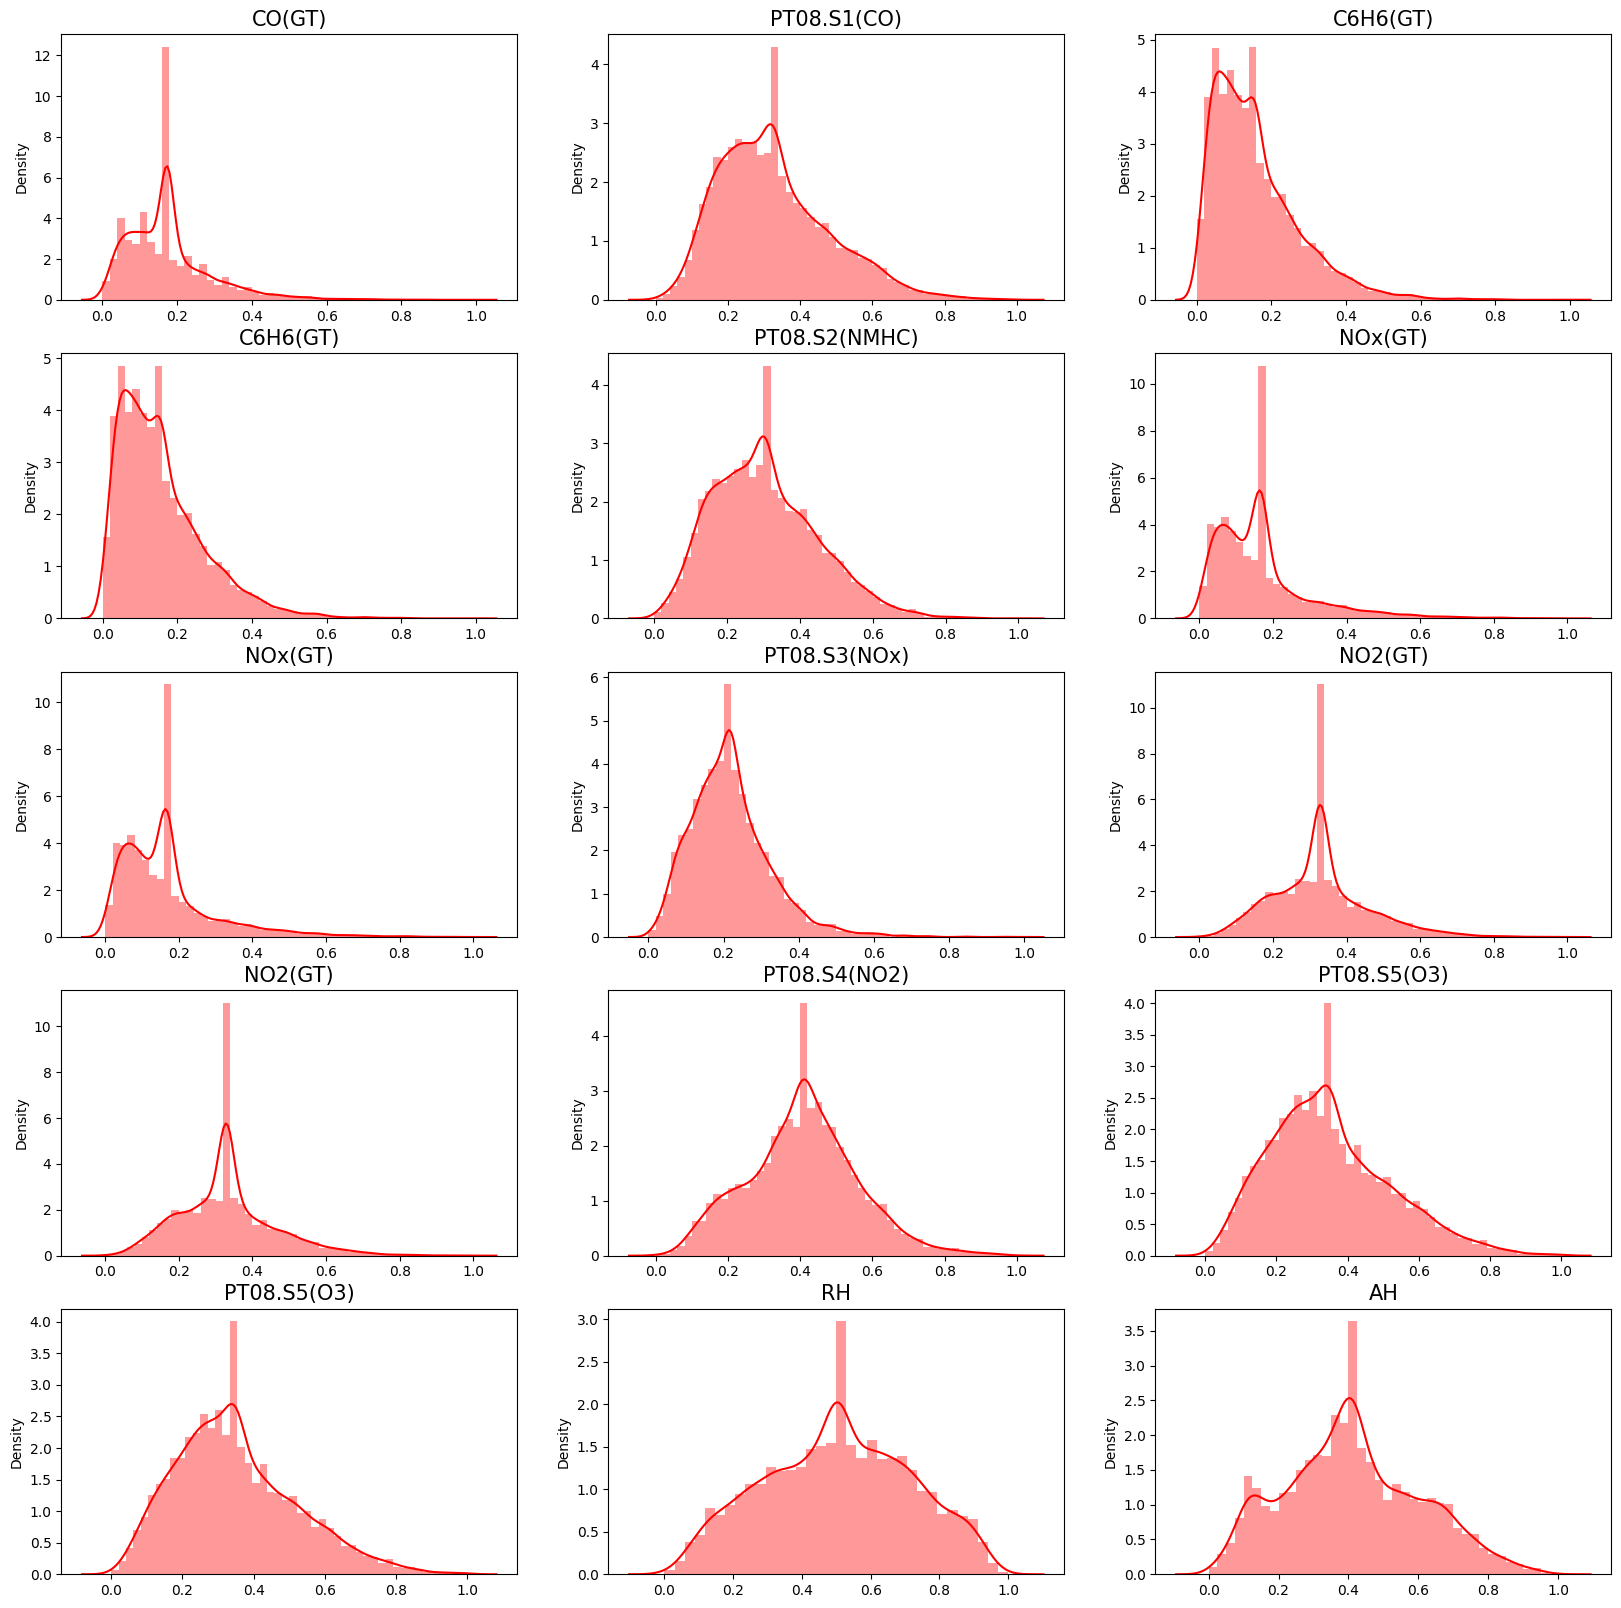

In [444]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(X[X.columns[i*2+j]], ax=ax[i][j], color="red")
        g.set(xlabel=None)
        g.set_title(X[X.columns[i*2+j]].name, fontsize = 15)

### Handling high-correlated data

Linear regression cannot perform a good fitting process with highly-correlated features.
Given a specific threshold, we will remove the most correlated variables in order to obtain consistent results.

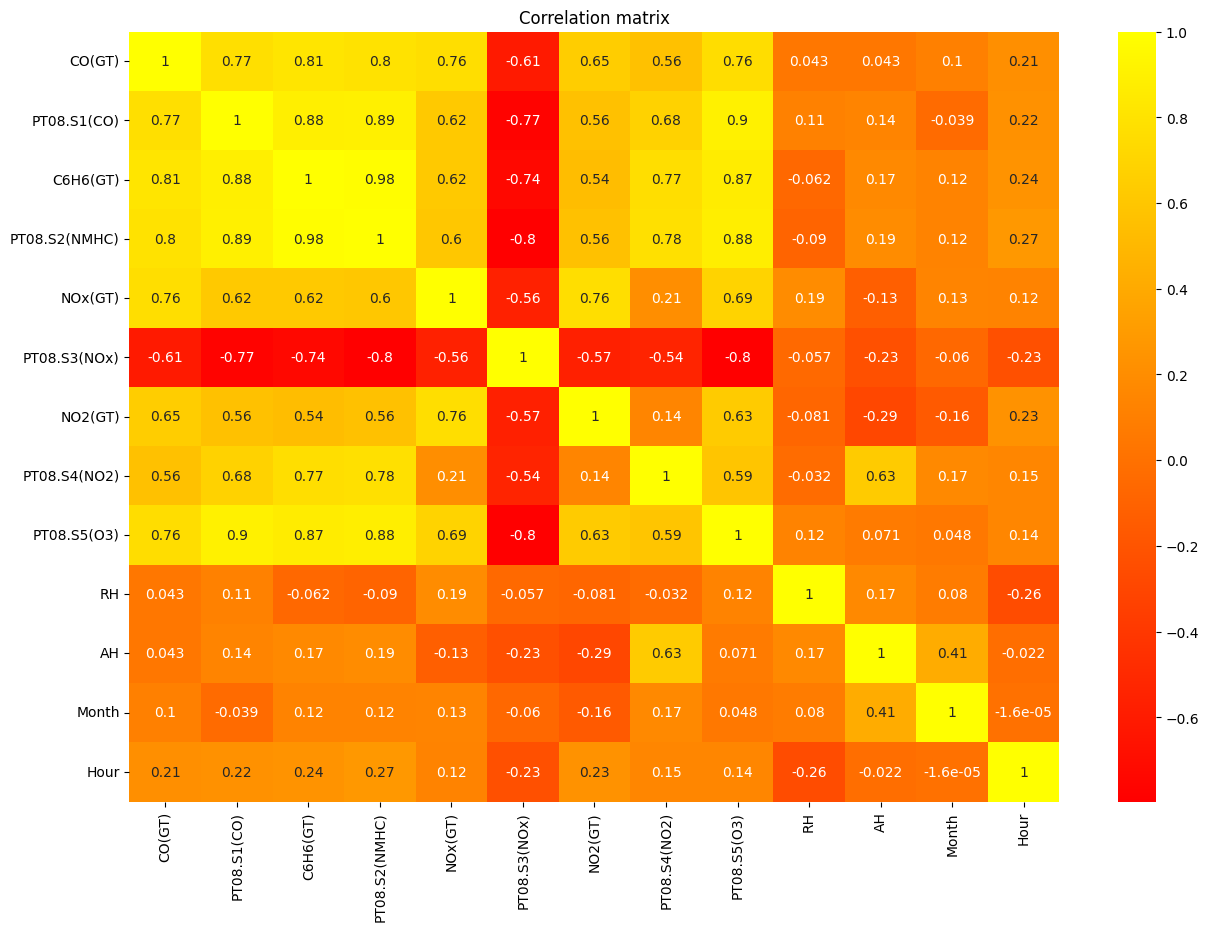

In [41]:
# Computing and plotting the correlation matrix of the final dataset
plt.figure(figsize=(15, 10))
correlation_matrix = X.corr() #.abs()
sns.heatmap(correlation_matrix, annot=True, cmap="autumn")
plt.title("Correlation matrix")
plt.show()

We remark that the upper left-hand corner contains highly-correlated variables.

In [61]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
HIGH_CORRELATION_THRESHOLD = 0.88
to_drop = [column for column in upper.columns if any(upper[column] > HIGH_CORRELATION_THRESHOLD)]
print(f"We drop the following variables: {to_drop}")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']


With a threshold of $0.88$, we have to remove the most high-correlated variables which are : `C6H6(GT)`, `PT08.S2(NMHC)` and `PT08.S5(O3)`.

In [64]:
# Drop selected features
try:
    if len(to_drop) != 0:
        print(f"We drop the following variables: {to_drop}")
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
    else:
        print("High-correlated features have already been removed by the user.")
except:
    print("High-correlated features have already been removed by the user.")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']
High-correlated features have already been removed by the user.


In [453]:
# (Obsolete) Alternative method to find pairs of heavy-correlated variables
#c = df.corr().abs()
#s = c.unstack()
#so = s.sort_values(kind="quicksort")
#so.drop(so)
#HIGH_CORRELATION_THRESHOLD = 0.85
#so[(so != 1.0) & (so > HIGH_CORRELATION_THRESHOLD)].drop_duplicates().keys()

### Train/test dataset split

In [65]:
# Size setting
SIZE_SAMPLE_TEST = 0.2
SIZE_SAMPLE_VALIDATION = 0.25

# Creation of training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = SIZE_SAMPLE_TEST)
# Shuffling
X_train.sample(frac=1)
X_test.sample(frac=1)

,CO(GT),PT08.S1(CO),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),RH,AH,Month,Hour
8426,0.322034,0.516870,0.371699,0.069039,0.778107,0.423112,0.826415,0.260959,0.090909,0.086957
6760,0.415254,0.325078,0.633040,0.217490,0.479290,0.407043,0.503575,0.410903,1.000000,0.043478
6514,0.173962,0.129935,0.097495,0.318509,0.183432,0.248201,0.782390,0.394566,1.000000,0.173913
4267,0.144068,0.297918,0.165807,0.172385,0.328672,0.408273,0.150943,0.550261,0.727273,0.565217
8509,0.025424,0.122039,0.058903,0.447268,0.189349,0.081385,0.547170,0.100718,0.090909,0.304348
...,...,...,...,...,...,...,...,...,...,...
7356,0.067797,0.287150,0.076506,0.229140,0.215976,0.267986,0.754717,0.383619,0.000000,0.260870
3737,0.093220,0.219670,0.054841,0.231258,0.316568,0.459532,0.249057,0.726629,0.636364,0.478261
8267,0.025424,0.161522,0.023020,0.392630,0.097633,0.109263,0.489308,0.144114,0.090909,0.217391
4598,0.084746,0.183776,0.117806,0.301991,0.233728,0.344424,0.509434,0.494698,0.727273,0.347826


In [67]:
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                        #          test_size=SIZE_SAMPLE_VALIDATION)

# Shuffling
#X_train.sample(frac=1)
#X_val.sample(frac=1)

#### Outliers detection & correction

In [462]:
def apply_outliers_detect_col(col):
    """
    Function returning an outliers-corrected column from the initial column : col
    :param col: Initial column
    """
    return winsorize(col, limits=[0.05, 0.05])

def apply_outliers_detect(df):
    """
    Function returnin an outliers-corrected dataframe from the initial dataframe : df
    :param df: Initial dataframe
    """
    return df.apply(apply_outliers_detect_col, axis = 0)

# Applying the filtering of outliers on the train dataset ONLY
#X_train = apply_outliers_detect(X_train)
#X_train

### Final steps

In [466]:
# Saving the pre-processed output DataFrame within an intermediary file
X.to_csv(path_or_buf="data/clean_data_X.csv",
         sep=";",
         header=True)
Y.to_csv(path_or_buf="data/clean_data_Y.csv",
         sep=";",
         header=True)

In [470]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.0,0.174,0.112,0.0,0.093,0.174,0.212,1.0
PT08.S1(CO),9357.0,0.325,0.153,0.0,0.211,0.307,0.412,1.0
NOx(GT),9357.0,0.166,0.131,0.0,0.074,0.154,0.191,1.0
PT08.S3(NOx),9357.0,0.217,0.107,0.0,0.146,0.210,0.270,1.0
NO2(GT),9357.0,0.329,0.130,0.0,0.249,0.329,0.388,1.0
PT08.S4(NO2),9357.0,0.407,0.153,0.0,0.311,0.407,0.500,1.0
T,9357.0,0.435,0.186,0.0,0.299,0.434,0.559,1.0
RH,9357.0,0.504,0.214,0.0,0.345,0.504,0.663,1.0
AH,9357.0,0.411,0.193,0.0,0.274,0.406,0.543,1.0
Month,9357.0,0.483,0.313,0.0,0.182,0.455,0.727,1.0


## NN model

We want to study the effect of the following hyper-parameters:
- $\#$ of layers
- $\#$ of neurons
- learning rate
- regularization
- activation functions
- impact of normalizing your dataset
- impact of noising your dataset (after normalization)

In [5]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from keras_visualizer import visualizer
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [6]:
# Simple assertion for technical reason
tf.keras.models.Sequential == tf.keras.Sequential

True

In [72]:
# Creation of the neural network

# WARNING: Il faut
model = Sequential()
model.add(
    Dense(units=12, input_dim=10, activation="relu")
)
model.add(
    Dense(8, activation='relu')
)
model.add(
    Dense(8, activation='linear')
)

In [55]:
model

In [73]:
# Compile model
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy", "mse", "mae"]
             )

In [74]:
# Fit step of the model
NB_EPOCHS = 200
model.fit(X_train, Y_train, 
          epochs=NB_EPOCHS,
          validation_split=0.2)

Epoch 1/200
188/188 [==============================] - 1s 2ms/step - loss: 2.4517 - accuracy: 1.6700e-04 - mse: 0.2101 - mae: 0.3491 - val_loss: 1.6952 - val_accuracy: 0.0000e+00 - val_mse: 0.1498 - val_mae: 0.2812
Epoch 2/200
188/188 [==============================] - 0s 1ms/step - loss: 1.4831 - accuracy: 0.0000e+00 - mse: 0.1397 - mae: 0.2612 - val_loss: 1.4498 - val_accuracy: 0.0000e+00 - val_mse: 0.1361 - val_mae: 0.2538
Epoch 3/200
188/188 [==============================] - 0s 1ms/step - loss: 1.4544 - accuracy: 0.0000e+00 - mse: 0.1351 - mae: 0.2500 - val_loss: 1.4366 - val_accuracy: 0.0000e+00 - val_mse: 0.1314 - val_mae: 0.2431
Epoch 4/200
188/188 [==============================] - 0s 1ms/step - loss: 1.4396 - accuracy: 0.0000e+00 - mse: 0.1286 - mae: 0.2350 - val_loss: 1.4194 - val_accuracy: 0.0000e+00 - val_mse: 0.1236 - val_mae: 0.2232
Epoch 5/200
188/188 [==============================] - 0s 1ms/step - loss: 1.4213 - accuracy: 0.0000e+00 - mse: 0.1240 - mae: 0.2149 - val_l

Epoch 39/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3753 - accuracy: 0.0000e+00 - mse: 0.1409 - mae: 0.1430 - val_loss: 1.3641 - val_accuracy: 0.0000e+00 - val_mse: 0.1392 - val_mae: 0.1415
Epoch 40/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3751 - accuracy: 0.0000e+00 - mse: 0.1411 - mae: 0.1426 - val_loss: 1.3640 - val_accuracy: 0.0000e+00 - val_mse: 0.1399 - val_mae: 0.1416
Epoch 41/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3750 - accuracy: 0.0000e+00 - mse: 0.1413 - mae: 0.1423 - val_loss: 1.3639 - val_accuracy: 0.0000e+00 - val_mse: 0.1399 - val_mae: 0.1410
Epoch 42/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3749 - accuracy: 0.0000e+00 - mse: 0.1415 - mae: 0.1421 - val_loss: 1.3638 - val_accuracy: 0.0000e+00 - val_mse: 0.1392 - val_mae: 0.1400
Epoch 43/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3748 - accuracy: 0.0000e+00 - mse: 0.1418 - mae: 0.1418 - 

Epoch 77/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1392 - mae: 0.1363 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1373 - val_mae: 0.1348
Epoch 78/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1393 - mae: 0.1367 - val_loss: 1.3631 - val_accuracy: 0.0000e+00 - val_mse: 0.1368 - val_mae: 0.1350
Epoch 79/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1392 - mae: 0.1365 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1372 - val_mae: 0.1348
Epoch 80/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1391 - mae: 0.1364 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1370 - val_mae: 0.1352
Epoch 81/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3742 - accuracy: 0.0000e+00 - mse: 0.1389 - mae: 0.1366 - 

Epoch 115/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1364 - mae: 0.1345 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1342 - val_mae: 0.1327
Epoch 116/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1363 - mae: 0.1346 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1338 - val_mae: 0.1325
Epoch 117/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1358 - mae: 0.1348 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1344 - val_mae: 0.1334
Epoch 118/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1358 - mae: 0.1343 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1339 - val_mae: 0.1325
Epoch 119/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1358 - mae: 0.13

Epoch 153/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1330 - mae: 0.1326 - val_loss: 1.3629 - val_accuracy: 0.0000e+00 - val_mse: 0.1309 - val_mae: 0.1305
Epoch 154/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1328 - mae: 0.1324 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1321 - val_mae: 0.1326
Epoch 155/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1330 - mae: 0.1326 - val_loss: 1.3629 - val_accuracy: 0.0000e+00 - val_mse: 0.1309 - val_mae: 0.1306
Epoch 156/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1328 - mae: 0.1323 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1303 - val_mae: 0.1305
Epoch 157/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3741 - accuracy: 0.0000e+00 - mse: 0.1326 - mae: 0.13

Epoch 191/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1299 - mae: 0.1300 - val_loss: 1.3631 - val_accuracy: 0.0000e+00 - val_mse: 0.1265 - val_mae: 0.1303
Epoch 192/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1297 - mae: 0.1299 - val_loss: 1.3629 - val_accuracy: 0.0000e+00 - val_mse: 0.1272 - val_mae: 0.1282
Epoch 193/200
188/188 [==============================] - 0s 1ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1297 - mae: 0.1298 - val_loss: 1.3630 - val_accuracy: 0.0000e+00 - val_mse: 0.1287 - val_mae: 0.1308
Epoch 194/200
188/188 [==============================] - 0s 2ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1295 - mae: 0.1298 - val_loss: 1.3629 - val_accuracy: 0.0000e+00 - val_mse: 0.1279 - val_mae: 0.1286
Epoch 195/200
188/188 [==============================] - 0s 2ms/step - loss: 1.3740 - accuracy: 0.0000e+00 - mse: 0.1294 - mae: 0.12

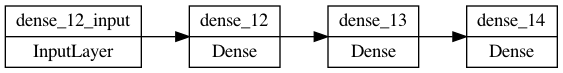

In [76]:
plot_model(model,
           to_file="img/graph_nn_1_alt.png",
           rankdir="LR")

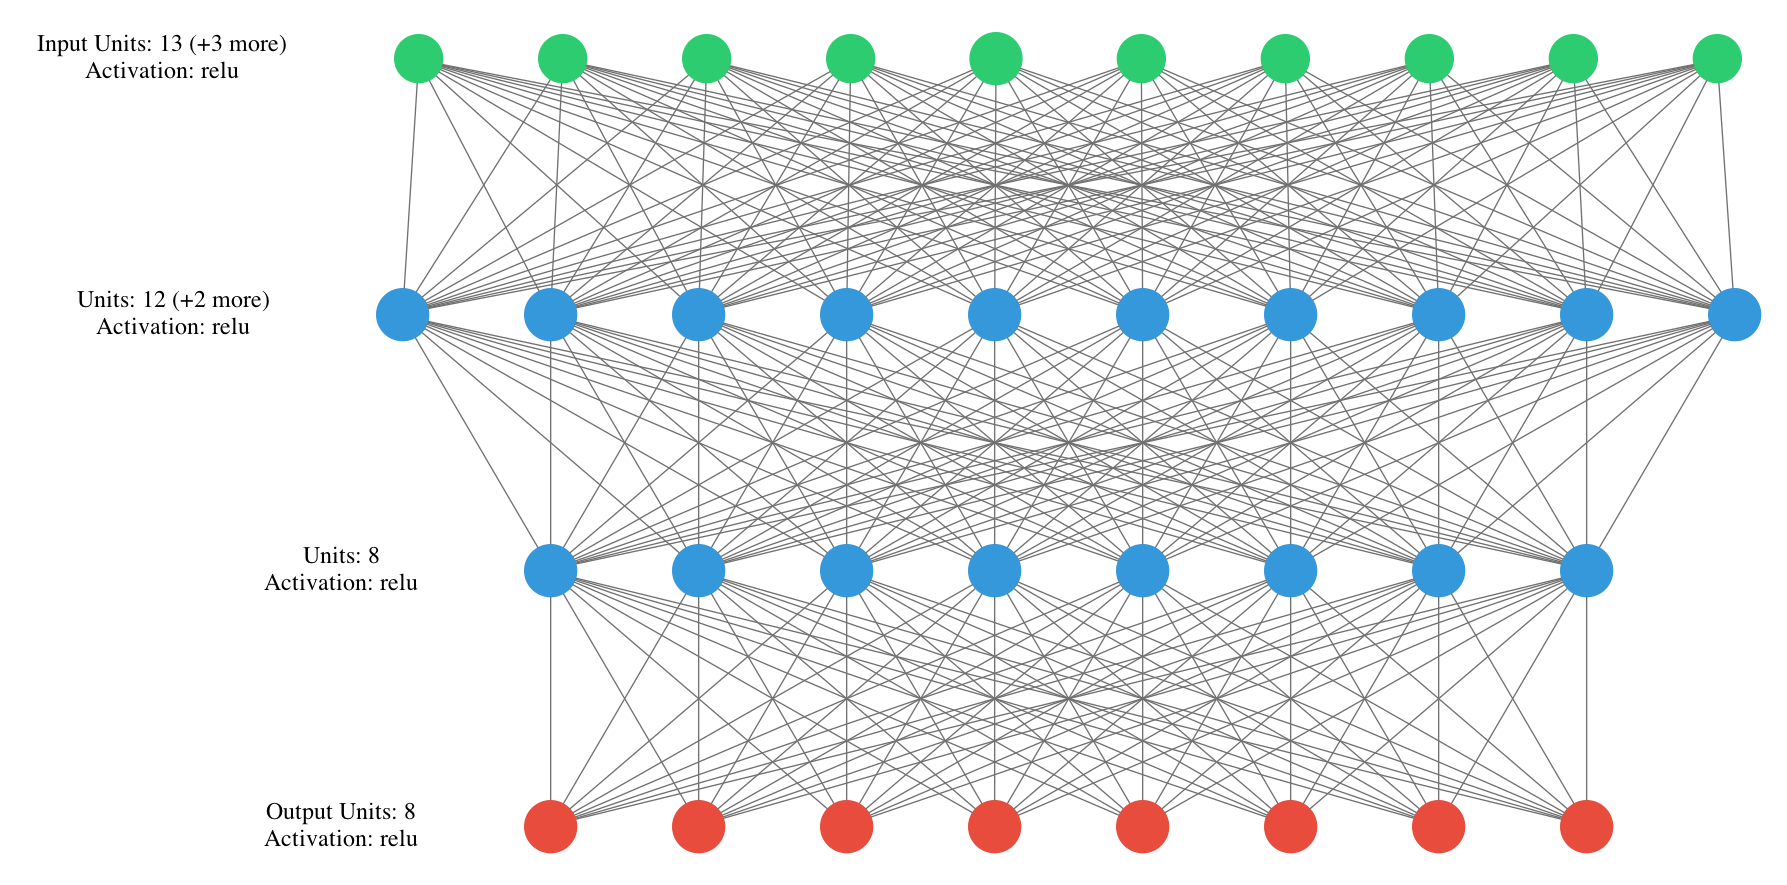

In [70]:
visualizer(model, 
           filename="img/graph_nn_1", 
           format='png', 
           view=False
          )
Image("img/graph_nn_1.png")